# Описание проекта


Описание данных:
- Технологический процесс
  - Rougher feed — исходное сырье
  - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
  - Rougher process (англ. «грубый процесс») — флотация
  - Rougher tails — отвальные хвосты
  - Float banks — флотационная установка
  - Cleaner process — очистка
  - Rougher Au — черновой концентрат золота
  - Final Au — финальный концентрат золота
- Параметры этапов
  - air amount — объём воздуха
  - fluid levels — уровень жидкости
  - feed size — размер гранул сырья
  - feed rate — скорость подачи

Наименование признаков:
- Возможные значения для блока [этап]:
  - rougher — флотация
  - primary_cleaner — первичная очистка
  - secondary_cleaner — вторичная очистка
  - final — финальные характеристики
- Возможные значения для блока [тип_параметра]:
  - input — параметры сырья
  - output — параметры продукта
  - state — параметры, характеризующие текущее состояние этапа
  - calculation — расчётные характеристики

# Содержание
1. Предобработка данных:
  - 1.1 Открываем данные;
  - 1.2 Проверка эффективности обогащения и расчет МАЕ;
  - 1.3 Анализ признаков в таблицах;
  - 1.4 Предобработка данных
2. Анализ данных:
  - 2.1 Рассмотрим измерения концентрации металлов (Au, Ag, Pb) на различнх этапах очистки;
  - 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках;
  - 2.3 Исследование суммарной концентрации всех веществ на разных стадиях:
    - в сырье концентрате;
    - в черновом концентрате;
    - в финальном концентрате
  - 2.4 Исследование аномалий
3. Построение модели:
  - 3.1 Функция для вычисления итоговой sMAPE;
  - 3.2 Обучение моделей для флотационного целевого признака:
    - 3.2.1 Базовая модель;
    - 3.2.2 Random Forest модель;
    - 3.2.3 Decision Tree модель
  - 3.3 Обучение моделей для финального целевого признака:
    - 3.3.1 Базовая модель;
    - 3.3.2 Random Forest модель
  - 3.4 Расчет итоговой sMAPE метрики

# Библиотеки

In [ ]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /usr/local/lib/python3.7/dist-packages (0.11.1)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor


#1. Предобработка данных


## 1.1 Открываем файлы и изучаем их

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


Всего имеем 3 массива данных, максимальный размер таблицы почти 23тыс строк на 87 столбцов, кол-во столбцов в обучающей и тестовой разнится, имеются пропуски во всех массивах.

## 1.2 Проверка эффективности обогащения

Нужно смоделировать процесс восстановления золота из золотосодержащей руды.
Эффективность обогащения рассчитывается по формуле
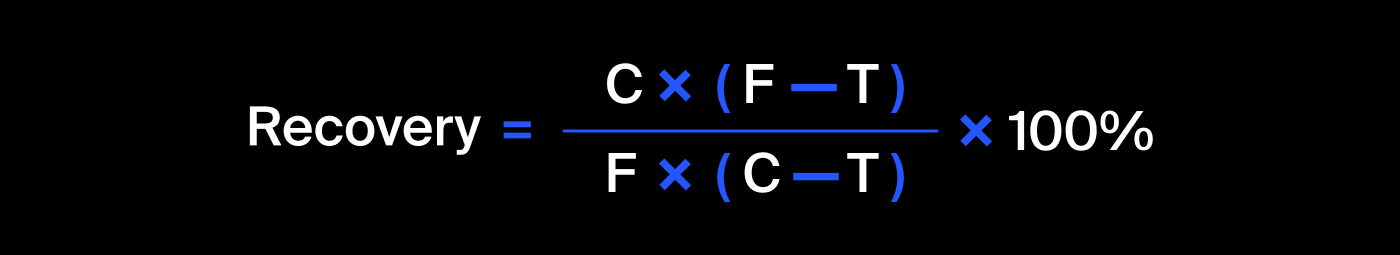
где:
  - C — доля золота в концентрате после флотации/очистки;
  - F — доля золота в сырье/концентрате до флотации/очистки;
  - T — доля золота в отвальных хвостах после флотации/очистки.
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

In [ ]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']
recovery = C*(F-T)/(F*(C-T))*100
mean_absolute_error(recovery[df_train['rougher.output.recovery'].dropna().index],df_train['rougher.output.recovery'].dropna())

9.444891926100695e-15

Значение крайне мало, что говорит о том, что наши расчеты эффективности обогощения очень близки к реальным показателям

## 1.3 Анализ отсутствующих признаков в тестовой таблице


In [ ]:
miss_columns = set(df_train) - set(df_test)
miss_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Данные несут информационный характер - выходные данные после каждого этапа технологического процесса. Очевидно, что эти данные убрали из тестовой выборки, чтобы лучше эмитировать реальную ситуацию, когда до начала работ, нет выходных данных после каждого технологического этапа

## 1.4 Предобработка данных

Колонки date в каждом массиве имеет тип данных object, необходимо преобразовать в формат datetime

In [ ]:
df_train['date'], df_test['date'], df_full['date'] = [pd.to_datetime(df, format = '%Y-%m-%d %H:%M:%S') for df in [df_train['date'], df_test['date'], df_full['date']]]

Заполним пропуски методом ffill , потому что у нас данные отсортированы по времени, а соседние по времени данные могут быть одинаковыми

In [ ]:
df_train = df_train.set_index('date').fillna(method='ffill')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16860 non-null  float64
 1   final.output.concentrate_pb                         16860 non-null  float64
 2   final.output.concentrate_sol                        16860 non-null  float64
 3   final.output.concentrate_au                         16860 non-null  float64
 4   final.output.recovery                               16860 non-null  float64
 5   final.output.tail_ag                                16860 non-null  float64
 6   final.output.tail_pb                                16860 non-null  float64
 7   final.output.tail_sol                               16860 non-null  float64
 8   final.output.tail_au                     

In [ ]:
df_test = df_test.set_index('date').fillna(method='ffill')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5856 non-null   float64
 1   primary_cleaner.input.depressant            5856 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5856 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5856 

In [ ]:
df_full = df_full.set_index('date').fillna(method='ffill')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22716 non-null  float64
 1   final.output.concentrate_pb                         22716 non-null  float64
 2   final.output.concentrate_sol                        22716 non-null  float64
 3   final.output.concentrate_au                         22716 non-null  float64
 4   final.output.recovery                               22716 non-null  float64
 5   final.output.tail_ag                                22716 non-null  float64
 6   final.output.tail_pb                                22716 non-null  float64
 7   final.output.tail_sol                               22716 non-null  float64
 8   final.output.tail_au                     

По итогам 1ого пункта мы загрузили и осмотрели данные, рассчитали эффективность обогащения: получили среднее абсолютное отклонение расчетов от реальных данных примерно на 9.5*10 в -15 степени, что крайне мало. Мы выявили, что в  тестовой выборке отсутствуют столбцы с выходными данных после каждого этапа очистки. Мы заполнили пропуски в данных на значения соседних по времени данных

# 2. Анализ данных

## 2.1 Рассмотрим измерения концентрации металлов (Au, Ag, Pb) на различнх этапах очистки

In [ ]:
# Создадим функцию отрисовки графиков
def draw_vboxplot(df, met):
  plt.figure(figsize=(18,15))
  ax = sns.lineplot(x = df.columns, y = [df[col].median() for col in df.columns], label = 'Кривая динамики')
  ax = sns.violinplot(data = pd.melt(df), y = 'value', x = 'variable')
  plt.title(f'График изменения концентрации {met} после каждого этапа очистки')
  plt.ylabel('Концентрация металла')
  plt.xlabel('Этапы очистки')
  ax.set_xticklabels(['Изначальные даные','После флотации','После первичной очистки','Итоговые данные'])
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
# Выделим отдельно выборки для каждого типа металла
df_au, df_ag, df_pb = [df_full[['rougher.input.feed_'+x, 'rougher.output.concentrate_'+x, 'primary_cleaner.output.concentrate_'+x, 'final.output.concentrate_'+x]] for x in ['au','ag','pb']]

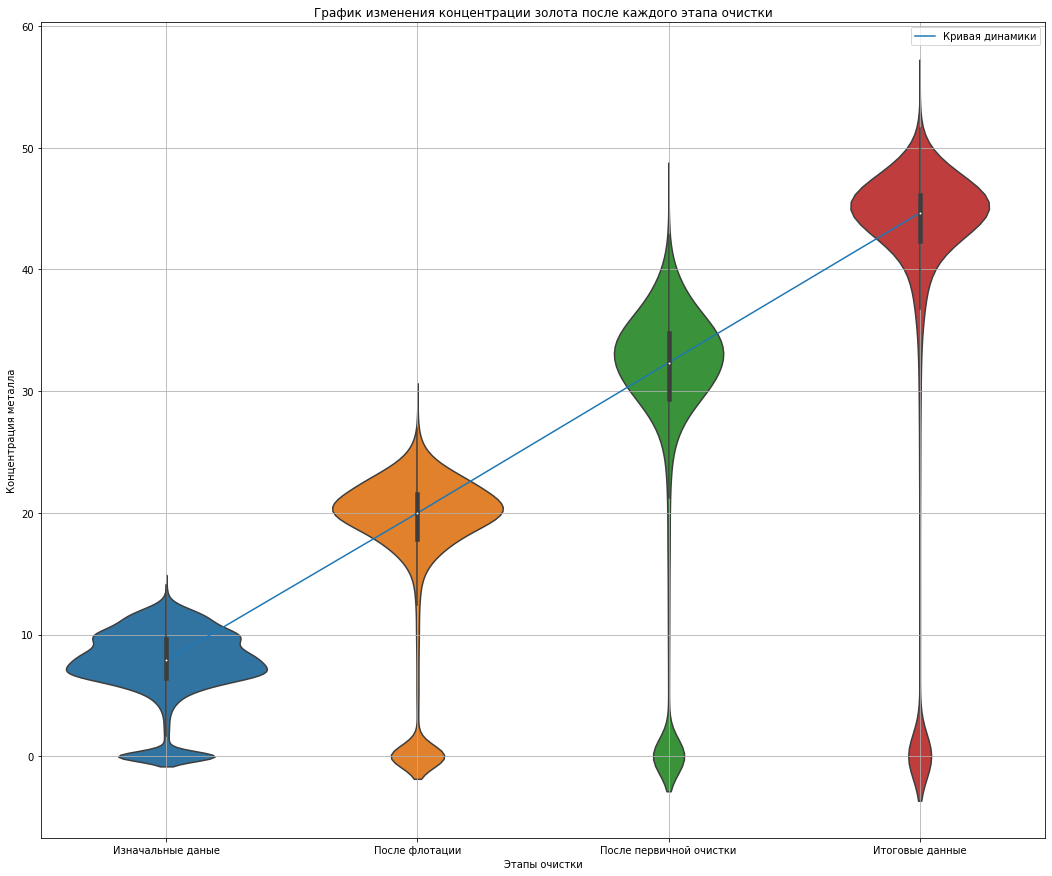

In [ ]:
draw_vboxplot(df_au, 'золота')

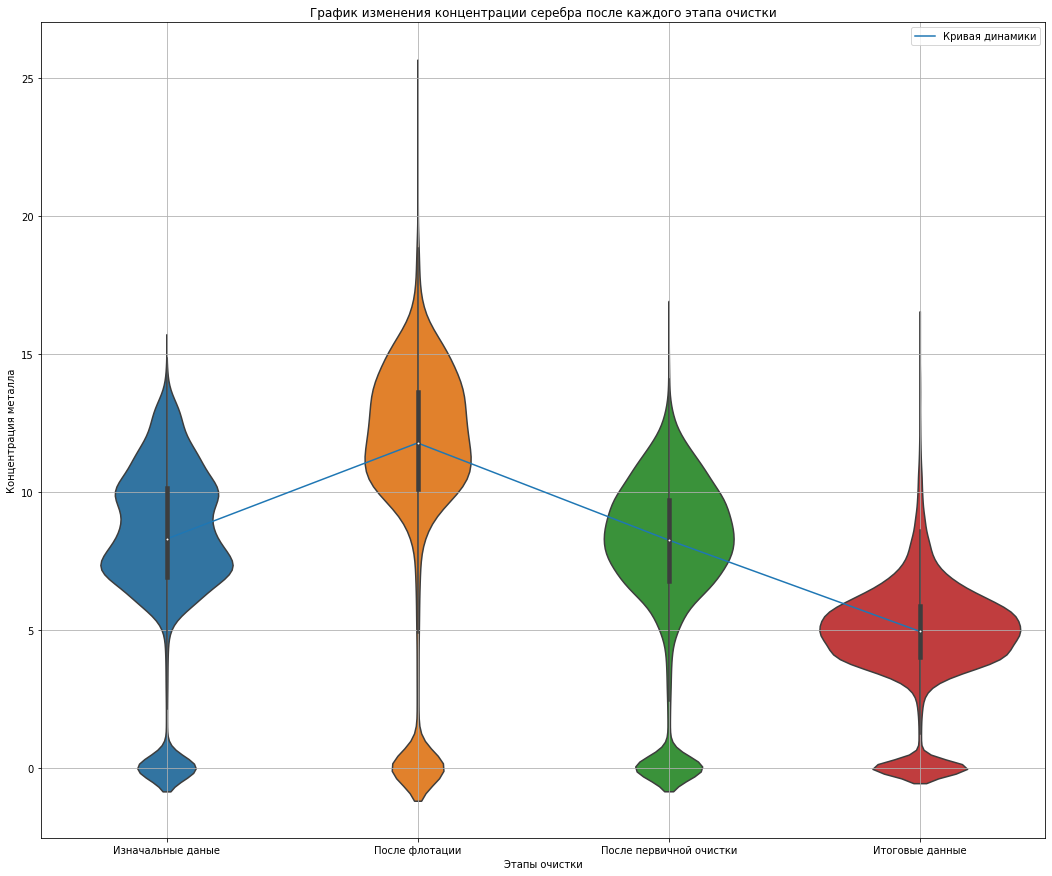

In [ ]:
draw_vboxplot(df_ag, "серебра")

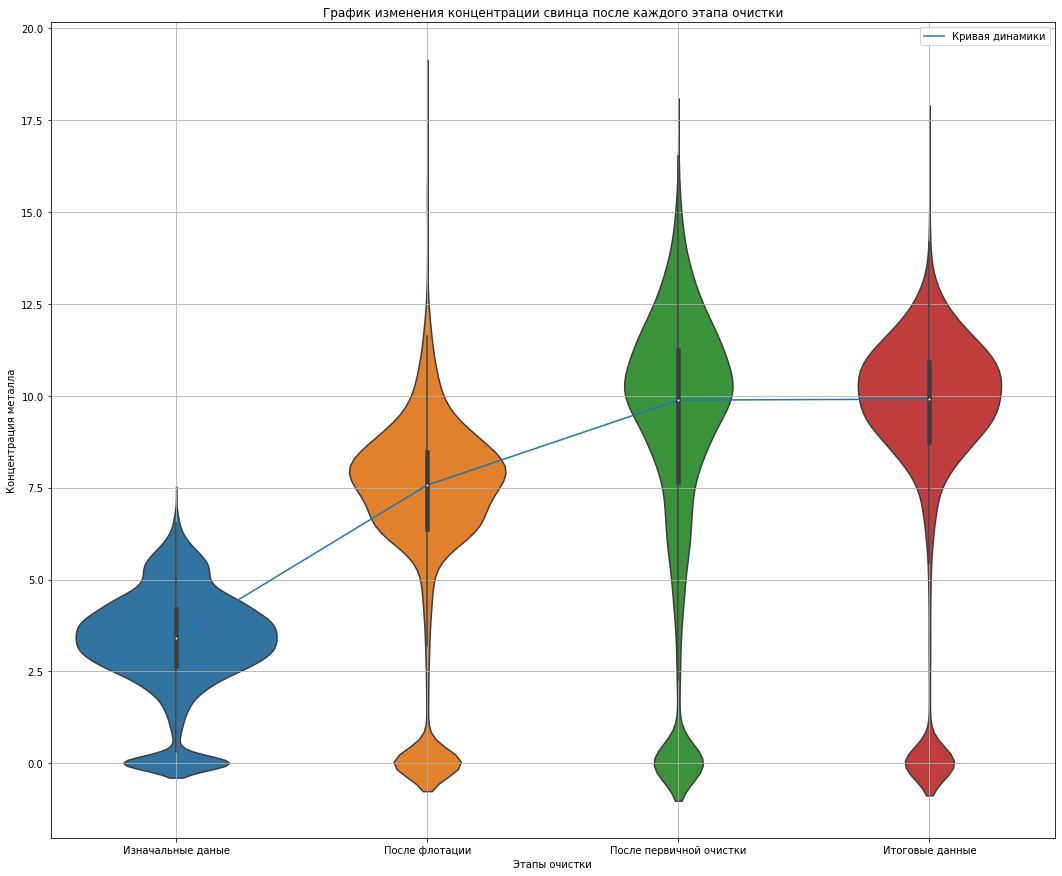

In [ ]:
draw_vboxplot(df_pb, 'свинца')

Из графиков выше мы увидели, что после каждого этапа очистки концентрация золота увеличивается, концентрация серебра падает, а концентрация свинца в итоге остается такой же, как и после первой очистки (но все равно больше, чем изначально)

## 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

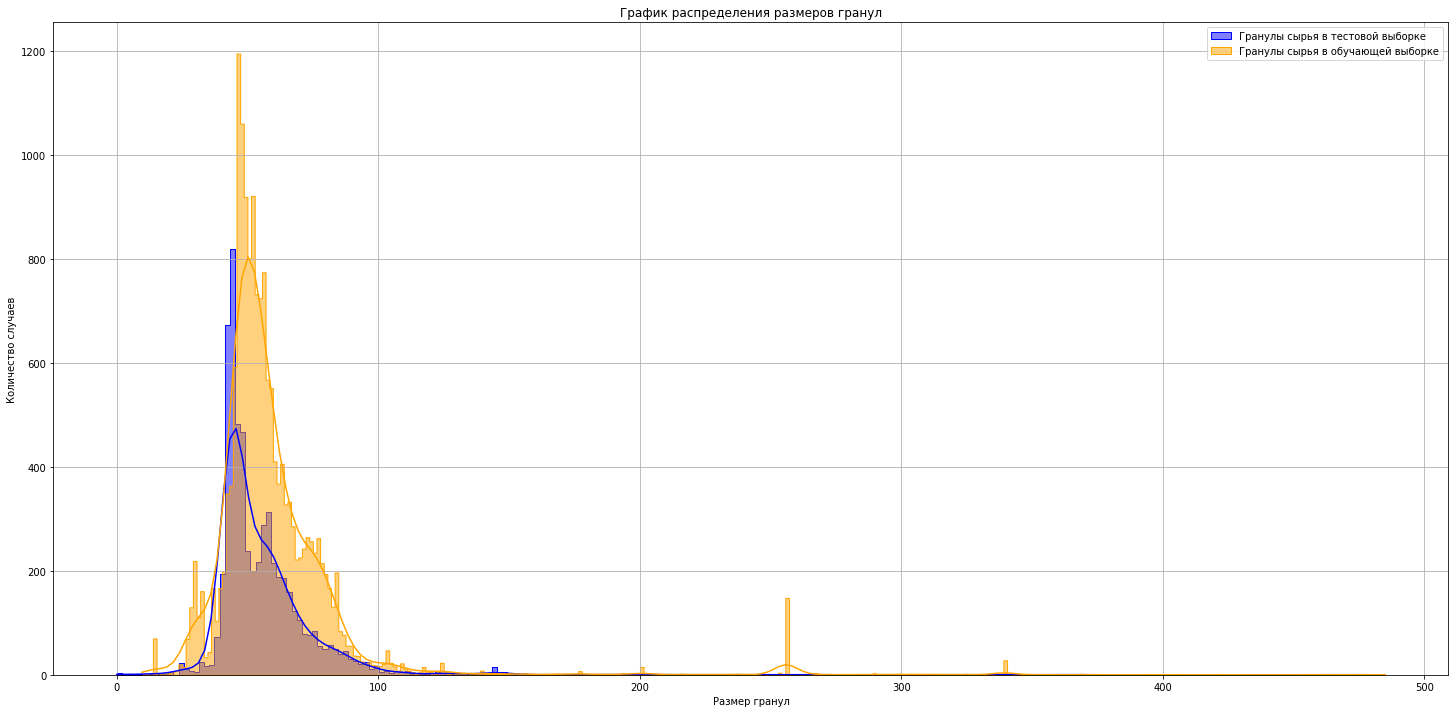

In [ ]:
plt.figure(figsize=(25,12))
sns.histplot(data=df_test, x = 'rougher.input.feed_size', color = 'blue', kde = True, element="step", label = 'Гранулы сырья в тестовой выборке')
sns.histplot(data=df_train, x = 'rougher.input.feed_size', color = 'orange', kde = True, element="step", label = 'Гранулы сырья в обучающей выборке')
plt.title('График распределения размеров гранул')
plt.ylabel('Количество случаев')
plt.xlabel('Размер гранул')
plt.grid()
plt.legend()
plt.show()

Видим, что распределения на обучающей и тестовой выборке похожи, имеется одинаковая форма правого спуска, следовательно, наши дальнейшие расчеты не приведут к ошибкам оценки модели

## 2.3 Исследование суммарной концентрации всех веществ на разных стадиях

In [ ]:
# Создадим функциюб отрисовки суммарной концентрации
def conc_sum(df):
  plt.figure(figsize=(18,15))
  ax = sns.lineplot(x = df.columns, y = [df[col].median() for col in df.columns], label = 'Кривая динамики')
  ax = sns.violinplot(data = pd.melt(df), y = 'value', x = 'variable')
  plt.title('График суммарной концентрации всех веществ на разных этапах очистки')
  plt.ylabel('Концентрация веществ')
  ax.set_yticks(np.arange(-10, 110, 10))
  plt.xlabel('Этапы очистки')
  plt.grid()
  plt.show()

In [ ]:
# Соберем данные по суммарной концентрации металлов в отдельную таблицу
df_metal = pd.DataFrame({'Сырье' : df_full[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol']].sum(axis = 1),
                         'Черновой концентрат' : df_full[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']].sum(axis = 1),
                         'Финальный концентрат' : df_full[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']].sum(axis = 1)})
df_metal.shape

(22716, 3)

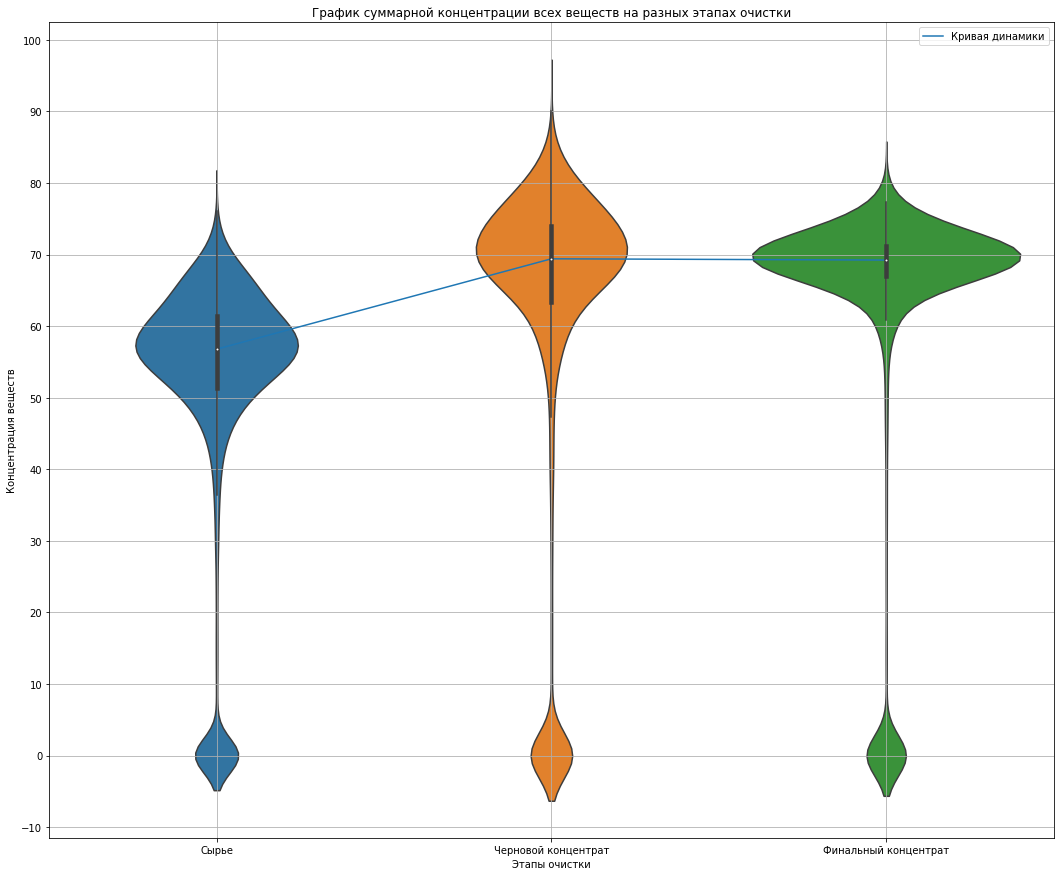

In [ ]:
conc_sum(df_metal)

Из графика видно, что суммарная концентрация веществ после флотации вышла на "плато" до финальной стадии очистки

## 2.4 Исследование аномалий

Из графиков распределений п.2.3 видны "хвосты", выбросы и совсем отрицательные значения. Будем считать их аномалиями, удалим их.

In [ ]:
# Удалим аномалии, взяв за пороговое значение 10, так как все хвосты находятся ниже этого значения
new_df = []
for col in df_metal.columns:
  new_df.append(df_metal[df_metal[col]>10].index)

set_index = set(new_df[0]).intersection(set(new_df[1])).intersection(set(new_df[2]))
print(len(set_index))

19820


19820 строки удовлетворяют нашему условию, убедимся на выборке, построим графики, затем применим эти индексы к обучающей и тестовой выборкам

In [ ]:
df_metal = df_metal.loc[set_index,:]
df_metal.shape

(19820, 3)

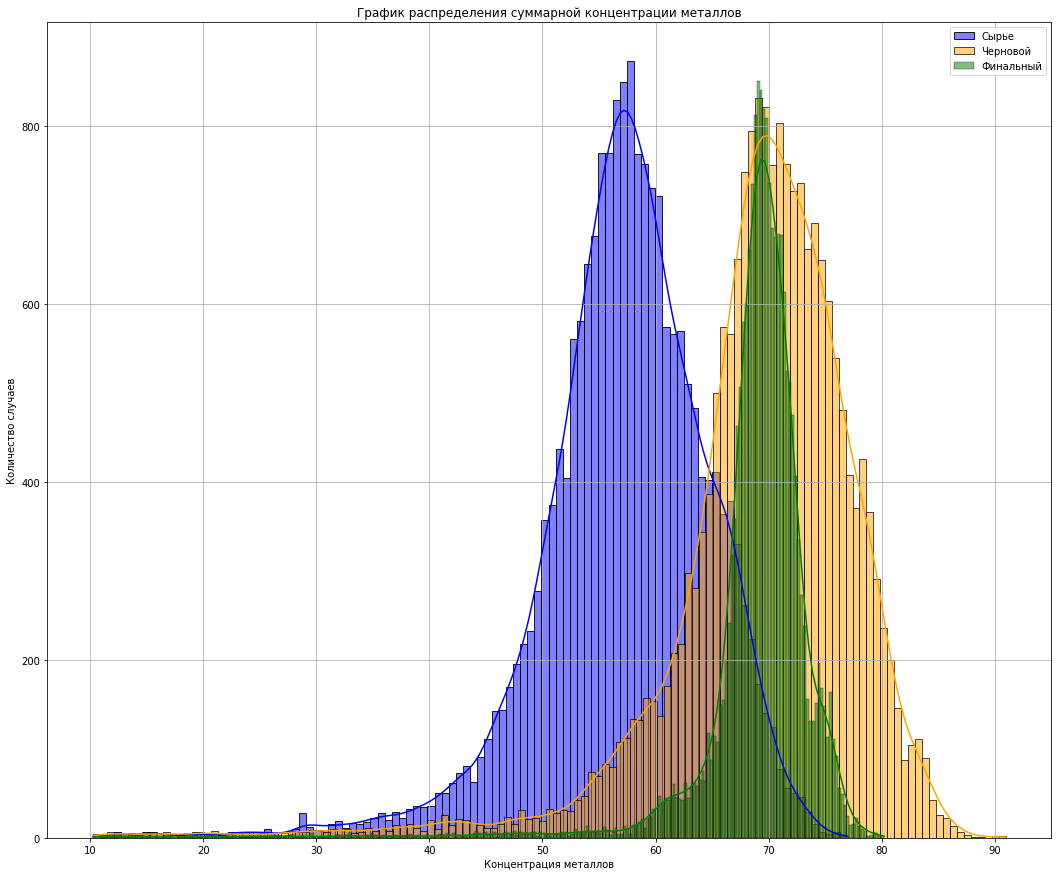

In [ ]:
# Построим график распределения суммарной концентрации металлов
plt.figure(figsize=(18,15))
sns.histplot(data=df_metal, x = 'Сырье', kde = True, label = 'Сырье', color = 'blue')
sns.histplot(data=df_metal, x = 'Черновой концентрат', kde = True, label = 'Черновой', color = "orange")
sns.histplot(data=df_metal, x = 'Финальный концентрат', kde = True, label = 'Финальный', color = 'green')
plt.title('График распределения суммарной концентрации металлов')
plt.ylabel('Количество случаев')
plt.xlabel('Концентрация металлов')
plt.grid()
plt.legend()
plt.show()

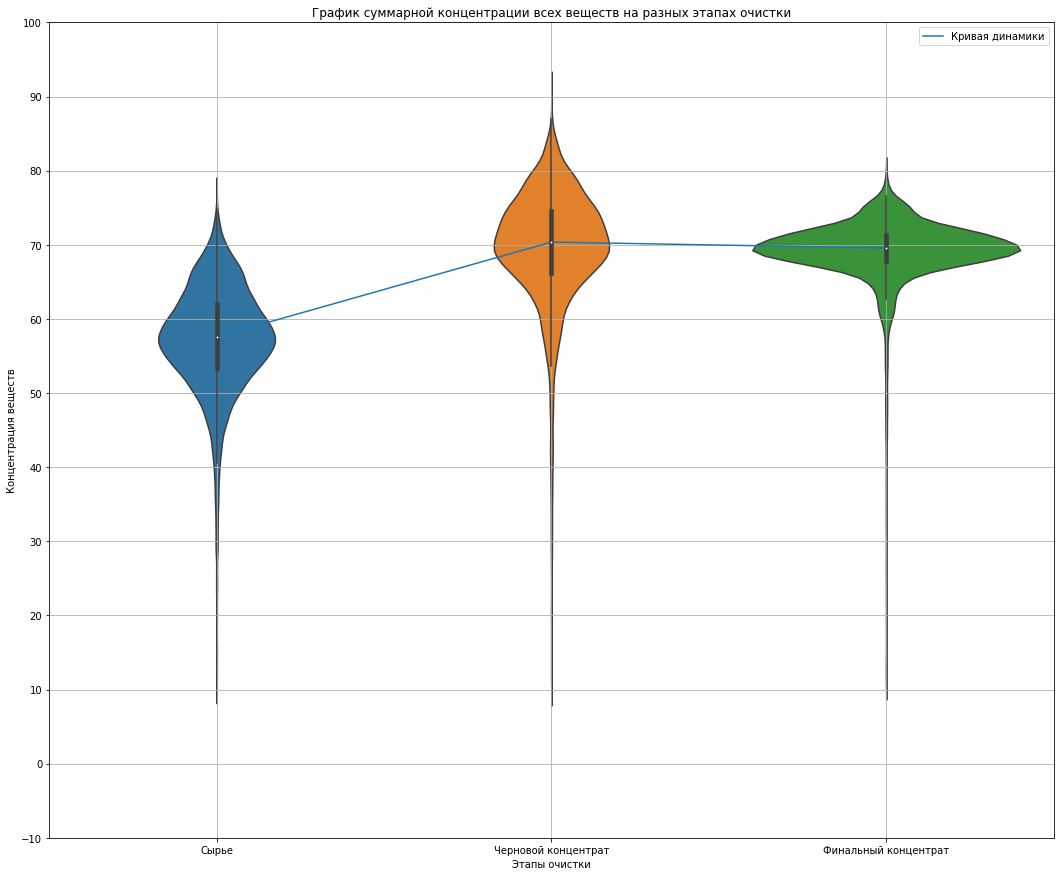

In [ ]:
conc_sum(df_metal)

После удаления аномалий распределения суммарной концентрации металлов на разных технологических этапах выглядят заметно лучше

In [ ]:
train_index = set(set_index).intersection(set(df_train.index))
print(len(train_index))

14550


In [ ]:
df_train = df_train.loc[train_index,:]
df_train.shape

(14550, 86)

In [ ]:
test_index = set(set_index).intersection(set(df_test.index))
print(len(test_index))

5270


In [ ]:
df_test = df_test.loc[test_index,:]
df_test.shape

(5270, 52)

Мы удалили аномалии в обучающей и тестовой выборке согласно индексам нашего "фильтра", потерялось примерно 18% данных, что с одной стороны много, с другой стороны - приемлимо, потому что отрицательные значения или нулевые значения могут означать ошибки в работе датчиков, регистрирующих концентрации

# 3. Построение модели

## 3.1 Функция для вычисления итоговой sMAPE

sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Формула для расчета sMAPE
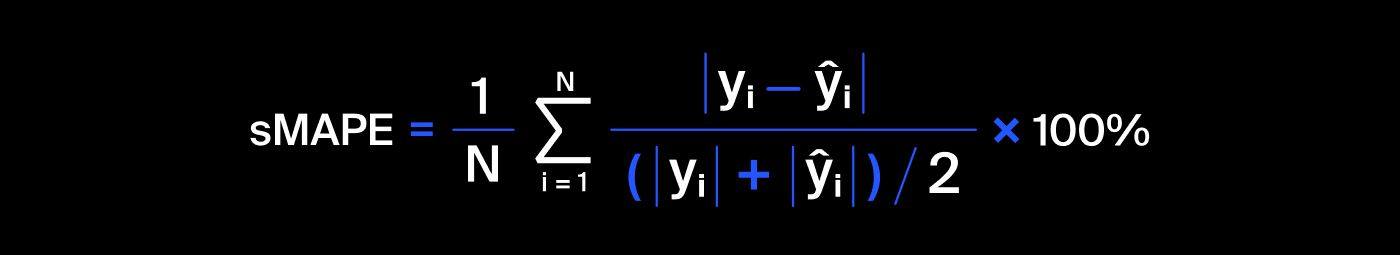

где Yi - значение целевого признака для объекта в выборке, на которой измеряется качество;
    Yi(с шапкой) - значение предсказания для объекта в тестовой выборке;
    N - количество объектов в выборке

In [ ]:
# Создадим функцию расчета sMAPE
def smape(pred, target):
  return np.sum(np.abs(target - pred)/(np.abs(target) + np.abs(pred))) * 200/len(target)

Формула для расчета итоговой sMAPE
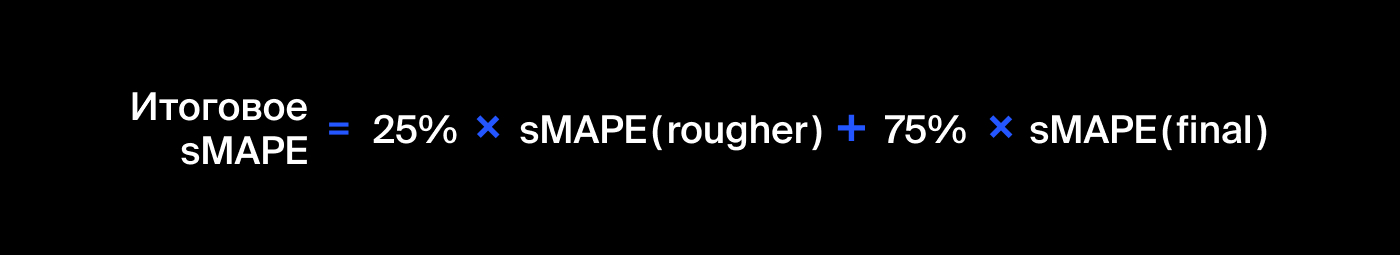

In [ ]:
# Создадим функцию расчета итоговой sMAPE
def final_smape(smape_rougher, smape_final):
  return 0.25 * smape_rougher + 0.75 * smape_final

In [ ]:
scor = make_scorer(smape, greater_is_better = False)

## 3.2 Обучение моделей для флотационного целевого признака

Будем одновременно обучать модели считать эффективность обогащения черного и финального концентрата

In [ ]:
# Создадим словарь, где будем хранить результат метрики МАЕ для каждой модели
smape_rougher_dict = {}

### 3.2.1 Базовая модель

In [ ]:
# Подготовим данные чернового концентрата для прогнозирования
rougher_columns = [col for col in df_test.columns if 'rougher' in col]
X_train_rougher = df_train[rougher_columns]
y_train_rougher= df_train['rougher.output.recovery']
X_train_rougher.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
date,,,,,,,,,,,,,,,,,,,,,,
2016-07-17 17:59:59,9.860494,2.691214,479.767321,46.926058,37.308591,8.334177,13.011770,6.196236,13.001124,6.201975,998.994394,-499.743971,1499.184655,-399.899007,1450.378089,-399.431427,1306.735263,-399.314417,1200.387522,-399.861166,1100.642121,-399.645961
2016-07-31 05:59:59,8.903490,3.061575,400.760237,48.783852,34.946095,7.541661,10.003523,5.796840,9.994799,5.798699,1000.434422,-500.535831,1399.162045,-400.205461,1400.197685,-400.087141,1299.233473,-400.544667,1200.677810,-400.163081,1000.642829,-400.357421
2017-04-01 14:59:59,8.297121,3.724931,308.151736,50.771774,38.734036,8.006566,12.499768,5.507362,12.502202,5.497929,1300.191979,-299.807057,1601.800187,-350.308564,1600.615687,-351.431513,1402.739176,-350.817866,1199.652698,-349.207653,1199.562927,-350.379979
2016-02-24 16:00:00,11.592531,4.630852,351.232940,42.709873,29.901458,9.761939,10.552958,5.788394,10.575275,5.796476,1099.467985,-500.209840,1648.562606,-499.654649,1649.485799,-498.891596,1646.061948,-500.092693,1600.197674,-499.222456,1599.883558,-499.857280
2017-02-24 14:59:59,11.588496,5.476074,312.699014,47.955323,36.059149,11.603353,11.998727,4.499023,11.998838,4.499239,1298.542519,-299.819709,1300.146309,-500.103734,1299.572599,-500.451039,1198.474237,-500.638825,999.587353,-499.614728,999.715511,-500.539355


In [ ]:
X_test_rougher = df_test[rougher_columns]
y_test_rougher = df_full.loc[df_test.index,'rougher.output.recovery']
print(X_test_rougher.shape, y_test_rougher.shape)

(5270, 22) (5270,)


In [ ]:
# Создадим базовую модель
linreg = LinearRegression().fit(X_train_rougher, y_train_rougher)
smape_rougher_dict['linreg'] = smape(linreg.predict(X_test_rougher), y_test_rougher)
print(smape_rougher_dict['linreg'])

4.904971361202849


In [ ]:
# Посчитаем после масштабирования данных
pipe = Pipeline([('scaler', StandardScaler()), ('linreg',LinearRegression())])
pipe.fit(X_train_rougher, y_train_rougher)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linreg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [ ]:
smape_rougher_dict['linreg_scaled'] = smape(pipe.predict(X_test_rougher), y_test_rougher)
print(smape_rougher_dict['linreg_scaled'])

4.9049713612028265


Базовая модель дает неплохие показатели sMAPE - разница между масштабированныеми данными и обычными совсем незаметна, будем сравнить прочие модели с базовой.

### 3.2.2 Random Forest модель

In [ ]:
# Найдем оптимальные параметры моедли RandomForest
params = {'n_estimators' : range(100, 120, 4),
          'max_depth' : range(1, 20),
          'random_state' : [0]}

grid_forest = GridSearchCV(RandomForestRegressor(), param_grid = params, scoring = scor, cv = 5, verbose = 3, n_jobs = -1).fit(X_train_rougher, y_train_rougher)                              

Fitting 5 folds for each of 95 candidates, totalling 475 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 475 out of 475 | elapsed: 96.9min finished


In [ ]:
print(grid_forest.best_params_)
smape_rougher_dict['forest'] = smape(grid_forest.best_estimator_.predict(X_test_rougher), y_test_rougher)
print(smape_rougher_dict['forest'])

{'max_depth': 19, 'n_estimators': 108, 'random_state': 0}
4.881389013485366


Лес выдал метрику sMAPE лучше, чем базовая модель линейной регрессии, очень хорошо.

### 3.2.3 Decision Tree модель

In [ ]:
params = params = {'max_depth' : range(1, 20),
                   'random_state' : [0]}
grid_tree = GridSearchCV(DecisionTreeRegressor(), param_grid = params, scoring = scor, cv = 5, verbose = 3, n_jobs = -1).fit(X_train_rougher, y_train_rougher)  

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   18.3s finished


In [ ]:
print(grid_tree.best_params_)
smape_rougher_dict['tree'] = smape(grid_tree.best_estimator_.predict(X_test_rougher), y_test_rougher)
print(smape_rougher_dict['tree'])

{'max_depth': 16, 'random_state': 0}
7.412470459805217


Древо решений дало результат хуже базовой модели, поэтому мы ее не будем дальше рассматривать для расчета sMAPE на полных данных

### 3.2.4 Lasso модель

In [ ]:
clf = Lasso().fit(X_train_rougher, y_train_rougher) 
smape_rougher_dict['lasso'] = smape(clf.predict(X_test_rougher), y_test_rougher)
print(smape_rougher_dict['lasso'])

5.095777438517983


## 3.3 Обучение моделей для финального целевого признака

In [ ]:
smape_final_dict = {}

In [ ]:
X_train_final = df_train[df_test.columns]
y_train_final = df_train['final.output.recovery']
X_train_final.shape,y_train_final.shape

((14550, 52), (14550,))

In [ ]:
X_test_final = df_test
y_test_final = df_full.loc[df_test.index,'final.output.recovery']
X_test_final.shape, y_test_final.shape

((5270, 52), (5270,))

### 3.3.1 Базовая модель

In [ ]:
linreg = LinearRegression().fit(X_train_final, y_train_final)
smape_final_dict['linreg'] = smape(linreg.predict(X_test_final), y_test_final)
print(smape_final_dict['linreg'])

8.790092592870657


sMAPE метрика почти в 2 раза ухудшилась на полных данных относительно sMAPE базового показателя для флотационных данных

### 3.3.2 Random Forest модель

In [ ]:
params = {'n_estimators' : range(109, 111),
          'max_depth' : range(18, 20),
          'random_state' : [0]}
grid_forest_2 = GridSearchCV(RandomForestRegressor(), param_grid = params, scoring = scor, cv = 5, verbose = 3, n_jobs = -1).fit(X_train_final, y_train_final) 

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.3min finished


In [ ]:
print(grid_forest_2.best_params_)
smape_final_dict['forest'] = smape(grid_forest_2.best_estimator_.predict(X_test_final), y_test_final)
print(smape_final_dict['forest'])

{'max_depth': 19, 'n_estimators': 110, 'random_state': 0}
9.204891973350305


sMAPE метркиа леса для полных данных оказалась хуже базовой модели, значит, модель Леса нам не подходит

### 3.3.3 Lasso модель

In [ ]:
clf = Lasso().fit(X_train_final, y_train_final)
smape_final_dict['lasso'] = smape(clf.predict(X_test_final), y_test_final)
print(smape_final_dict['lasso'])

8.29327798297831


# 3.4 Расчет итоговой sMAPE метрики

In [ ]:
print(final_smape(min(smape_rougher_dict.values()), min(smape_final_dict.values())))

7.4403057406050745


In [ ]:
# Сравним результат с DummyRegressor моделью
dum_r = DummyRegressor(strategy = 'median').fit(X_train_rougher, y_train_rougher)
dum_f = DummyRegressor(strategy = 'median').fit(X_train_final, y_train_final)
dummy_smape_r = smape(dum_r.predict(X_test_rougher), y_test_rougher)
dummy_smape_f = smape(dum_f.predict(X_test_final), y_test_final)

print(final_smape(dummy_smape_r, dummy_smape_f))

7.627262236581588


# Общий вывод

В нашем проекте мы исследовали процесс добычи и очистки золота из руды:
-  мы посчитали эффективность обогащения золота после флотационного процесса, сравнили его с реальными данными - получили, что наши расчеты верны, среднее абсолютное отклонение расчетной величины от реальных данных крайне мал;
- мы посчиатли изменение концентрации металлов (золота, серебра и свинца) после каждого этапа очистки, выявили, что:
  - концентрация золота рувеличивается; 
  - концентрация серебра уменьшается;
  - концентрация свинца после первичной очистки остается неизменной
- были исследованы аномалии суммарных концентраций веществ на разных этапах очистки, удалены значения концентраций ниже 10г/м3;
- были обучены модели для расчета симметричного абсолютного процентного отклонения (sMAPE), итоговое отклонение составило 7.39%, в то время как "глупая" модель дает 8.13%